In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
df = pd.read_csv("IEPK_TLS_10x10.xyzch")

In [3]:
df.sample(10)

,X,Y,Z,Classification,HeightAboveGround
6131801,246564.081,168985.319,0.313,2.0,0.000
3119412,246566.145,168982.611,0.215,2.0,0.000
27392917,246561.987,168991.125,0.856,2.0,0.000
16081707,246565.698,168985.104,3.485,1.0,3.245
11755592,246564.372,168983.094,2.040,1.0,1.030
23478527,246559.586,168989.617,0.401,2.0,0.000
26580679,246561.911,168990.047,0.700,2.0,0.000
11328050,246562.239,168983.062,1.854,1.0,1.516
3436190,246565.973,168983.299,0.217,2.0,0.000
3655077,246566.862,168983.217,0.380,2.0,0.000


In [4]:
df.count()[0]

31757686

In [5]:
df = df.sample(30000000)

In [6]:
df.count()[0]

30000000

In [7]:
x_max = df.X.max()
x_min = df.X.min()
y_max = df.Y.max()
y_min = df.Y.min()
z_max = df.Z.max()
z_min = df.Z.min()
print(x_max, x_min, y_max, y_min, z_max, z_min)

246568.61 246558.61 168991.47 168981.47 14.744 0.123


In [8]:
# c = 0
site_L = x_max - x_min
site_W = y_max - y_min
site_A = site_L * site_W
voxel_dim = 1.0

replicates = []
for frac in np.around(np.linspace(0.01,1,10),2):
    start = time.time()
    z0_list = []
    for rep in range(10):
        window_max_h = []
        voxel_count = []
        voxels = 0
        df_s = df.sample(frac=frac, replace=False)
        pts = df_s.count()[0]
        for i in np.arange(x_min, x_max, voxel_dim):
            for j in np.arange(y_min, y_max, voxel_dim):
                df_window = df_s[(df_s['X'].between(i, i+voxel_dim)) &
                                 (df_s['Y'].between(j, j+voxel_dim))]
                window_max_h.append(df_window.HeightAboveGround.max())
                for k in np.arange(z_min, z_max, voxel_dim):
                    df_voxel = df_s[(df_s['X'].between(i, i+voxel_dim)) &
                                    (df_s['Y'].between(j, j+voxel_dim)) &
                                    (df_s['Z'].between(k, k+voxel_dim))]
                    voxel_count.append(df_voxel.count()[0])
                    voxels += 1
        mu = np.median([c for c in voxel_count if c != 0])
        vi = [min(p/mu,1.0)*voxel_dim**3 for p in voxel_count]
        S_star = np.sum(vi)
        A_star = voxels * voxel_dim**3
        H_star = np.mean(window_max_h)
        z0_list.append(0.5*H_star*S_star/A_star)
        if frac == 1.0: break
    replicates.append([frac, z0_list, pts, pts/site_A, voxels])
    end = time.time()
    print(f"{frac} {np.around(np.mean(z0_list),3)} +/- {np.around(np.std(z0_list),3)} >>> took {np.around((end - start)/60.0,0)} minutes")

# print results using densest (last) point cloud
print(f"H* = {H_star}   S* = {S_star}   A* = {A_star}   z0 = {0.5*H_star*S_star/A_star}")

0.01 1.938 +/- 0.021 >>> took 1.0 minutes
0.12 2.219 +/- 0.015 >>> took 13.0 minutes
0.23 2.256 +/- 0.009 >>> took 26.0 minutes
0.34 2.278 +/- 0.011 >>> took 28.0 minutes
0.45 2.29 +/- 0.008 >>> took 45.0 minutes
0.56 2.295 +/- 0.008 >>> took 54.0 minutes
0.67 2.301 +/- 0.006 >>> took 65.0 minutes
0.78 2.305 +/- 0.005 >>> took 76.0 minutes
0.89 2.31 +/- 0.002 >>> took 48.0 minutes
1.0 2.314 +/- 0.0 >>> took 5.0 minutes
H* = 10.90268   S* = 636.8459475218658   A* = 1500.0   z0 = 2.3144425250425655


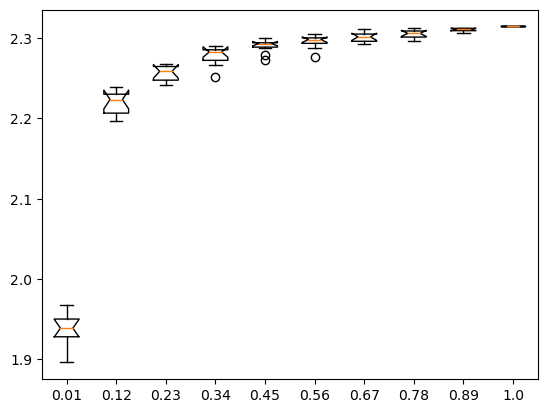

In [9]:
# check plot, not for publication
fig, ax = plt.subplots()
ax.boxplot([y[1] for y in replicates],
           notch=True,  # notch shape
           vert=True,  # vertical box alignment
           labels=[x[0] for x in replicates]);

In [10]:
# export results for plotting in another notebook
with open('IEPK_replicates_max', 'w') as outfile:
    outfile.write('\n'.join(str(i) for i in replicates))
    
# once this was complete, commas were manually inserted in the last row (frac = 1.0)
# so that fields r1 through r9, representing replicates 2 through 10, would match
# the overall schema.